In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

#XAI-related packages: LIME and SHAP
import lime
import lime.lime_tabular
import shap 
import shap.plots

C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\marsl\anaconda3\envs\ML\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)

    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y



In [4]:
##########################################################################################
###### Use function load_window_dataset() with datasets of for all scenarios  
###### using window length = 10 and spacing = 1. Finally, perform features scaling 
##########################################################################################

X=None 
y=None
length=10
spacing=1
folderpath='../Features_raw'

for filename in os.listdir(folderpath):   
    if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
        print(filename)
        label = 0
        if int(filename[9]) > 5:
          label = 1
        fullname = folderpath + '/' + filename
#------------------------------------------------------------
        X, y = load_window_dataset(X, y, fullname, label)
#------------------------------------------------------------
        print('current shape of X: ' +str(X.shape))
        print('current shape of y: ' +str(y.shape))

#All scenario correlated ONLY TO "length" and "spacing" variables
print(X)
print(y)
print(X.shape)
print(y.shape)

# Features scaling 
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(X)
print(y)
print(X.shape)
print(y.shape)



Scenario_1_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (21591, 6)
current shape of y: (21591,)
Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (43182, 6)
current shape of y: (43182,)
Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of X: (64773, 6)
current shape of y: (64773,)
Scenario_2_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (86364, 6)
current shape of y: (86364,)
Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (107955, 6)
current shape of y: (107955,)
Scenario_3_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (129546, 6)
current shape of y: (129546,)
Scenario_4_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (151137, 6)
current shape of y: (151137,)
Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (172728, 6)
current shape of y: (172728,)
Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of

In [5]:
def train_classifier_XGB(X_train, y_train): 
    xgb = XGBClassifier(use_label_encoder=False, eta = 0.7, max_depth= 7, subsample = 1, verbosity = 0)
    xgb.fit(X_train, y_train)
    return xgb

In [6]:
def train_classifier_DNN(X_train, y_train): 
    size = (50,) * 2
    dnn = MLPClassifier(hidden_layer_sizes=size, activation='tanh',
                            solver='adam', learning_rate='invscaling', max_iter=1000)
    dnn.fit(X_train, y_train)
    return dnn

In [7]:
def train_classifier_KNN(X_train, y_train): 
    knn = KNeighborsClassifier(leaf_size=43, p=1, n_neighbors=14)
    knn.fit(X_train, y_train)
    return knn

In [8]:
################################################################################################################
###### Split into into train/test and call train_classifier_XXX() functions
################################################################################################################

# Stratify garantees the split all the scenarios among train and test
# It's like shuffle and split
# random_state it's a seed to get the same output
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

print(y_test)
print(X_test)

print('Training XGB...')
xgb = train_classifier_XGB(X_train, y_train)

print('Training DNN...')
dnn = train_classifier_DNN(X_train, y_train)

print('Training KNN...')
knn = train_classifier_KNN(X_train, y_train)

[0 0 0 ... 0 1 1]
[[-1.42289769 -1.42291893  1.07022936  0.37409287 -1.41419948 -1.43599915]
 [-0.03791308 -0.03793432 -1.63484756 -1.5705945  -0.05162371 -0.02217269]
 [-0.07646647 -0.07648771 -1.69586433 -1.6960582  -0.0908794  -0.06039415]
 ...
 [-0.35184782 -0.35186906 -0.06875039  0.31136102 -0.35209478 -0.35146526]
 [ 1.61437504  1.61435379 -0.43485103  0.06043361  1.60261811  1.61326472]
 [ 0.49081912  0.49079787  1.17192398  1.06414322  0.50125773  0.48095401]]
Training XGB...
Training DNN...
Training KNN...


In [9]:
########################################################################################################
###### The function performance_eval() takes in input ground truth and predicted labels, 
###### prints results in a result file passed in input, and returns global metrics
########################################################################################################

def performance_eval(y_true, y_pred, lab, l_names, resfile):

    #Compute metrics and print/write them
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None) #F: average=None gives per-class results
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted') 
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted') 
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    with open(resfile, 'w') as result_file:
        result_file.write('Results for the TEST SET\n')
        result_file.write('Accuracy: {}\n'.format(accuracy))
        result_file.write('Precision per class: {}\n'.format(precision))
        result_file.write('Global Precision: {}\n'.format(global_precision))
        result_file.write('Recall per class: {}\n'.format(recall))
        result_file.write('Global Recall: {}\n'.format(global_recall))
        result_file.write('F1-score: {}\n'.format(f1score))
        result_file.write('Global F1-score: {}\n'.format(global_f1score))

    return accuracy, global_precision, global_recall, global_f1score 


In [10]:
##############################################################################################################
###### Load models into NEW models, perform prediction and evaluate performance using performance_eval() 
##############################################################################################################
res_folder = '1_1_Results'
if not os.path.exists(res_folder):
    os.makedirs(res_folder)

restestfileXGB = res_folder + '/XGB_sp_' + str(spacing) + 'w_' + str(length) + '_test_results.txt'
restestfileDNN = res_folder + '/DNN_sp_' + str(spacing) + 'w_' + str(length) + '_test_results.txt'
restestfileKNN = res_folder + '/KNN_sp_' + str(spacing) + 'w_' + str(length) + '_test_results.txt'

lbl = [0, 1]
label_names=['Attenuation', 'Filtering']

# Added to fix: 'XGBClassifier' object has no attribute '_le'
xgb._le = LabelEncoder().fit(y_test)

y_pred_XGB = xgb.predict(X_test)
y_pred_DNN = dnn.predict(X_test)
y_pred_KNN = knn.predict(X_test)

XGB_metrics = performance_eval(y_test, y_pred_XGB, lbl, label_names, restestfileXGB)
DNN_metrics = performance_eval(y_test, y_pred_DNN, lbl, label_names, restestfileDNN)
KNN_metrics = performance_eval(y_test, y_pred_KNN, lbl, label_names, restestfileKNN)

print('XGB metrics: ' +str(XGB_metrics))
print('****************')
print('DNN metrics: ' +str(DNN_metrics))
print('****************')
print('KNN metrics: ' +str(KNN_metrics))

XGB metrics: (0.9993330083887022, 0.9993330294265418, 0.9993330083887022, 0.9993329451254143)
****************
DNN metrics: (0.9983239697972517, 0.9983239056256707, 0.9983239697972517, 0.9983236621788626)
****************
KNN metrics: (0.9977766946290073, 0.9977798335297393, 0.9977766946290073, 0.9977753663819514)


In [11]:
# Features names
feature_names = ['mean', 'RMS', 'ptp', 'std', 'max', 'min']

#LIME tabular explainer with 4 arguments: 
# 1) train data X_train that will be used to fit the blackbox model
# 2) features' names f (for visualization purposes)
# 3) name of classes (for visualization purposes)
# 4) mode (classification or regression, we are dealing with a classification problem)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=label_names, mode='classification')


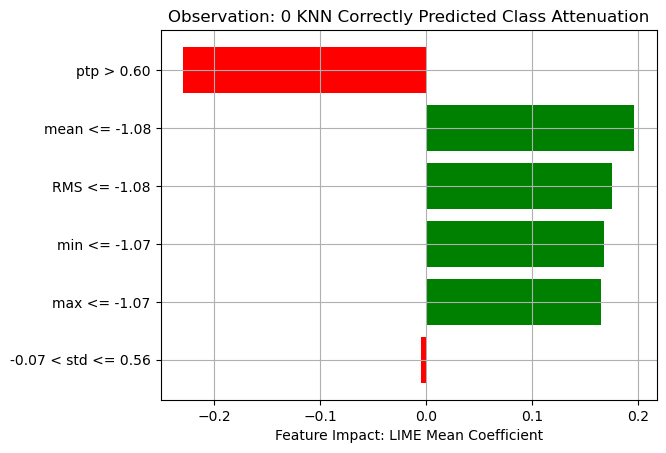

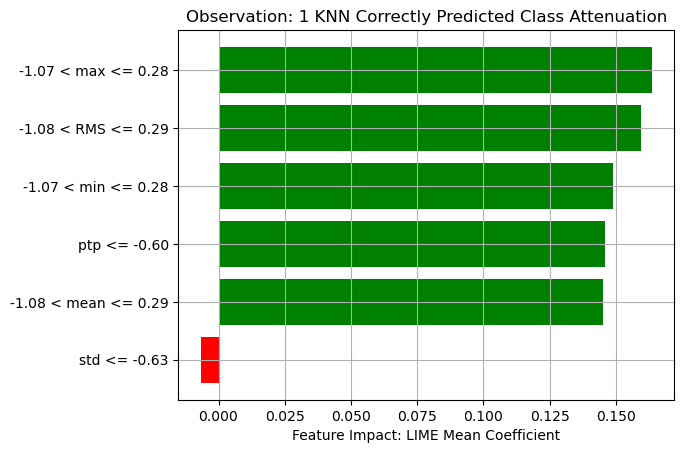

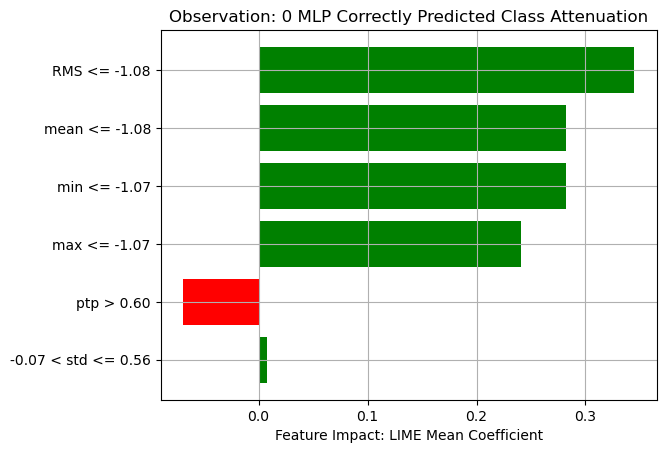

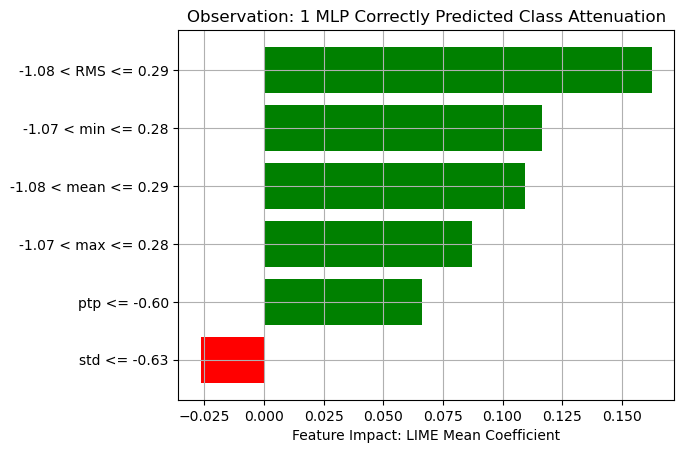

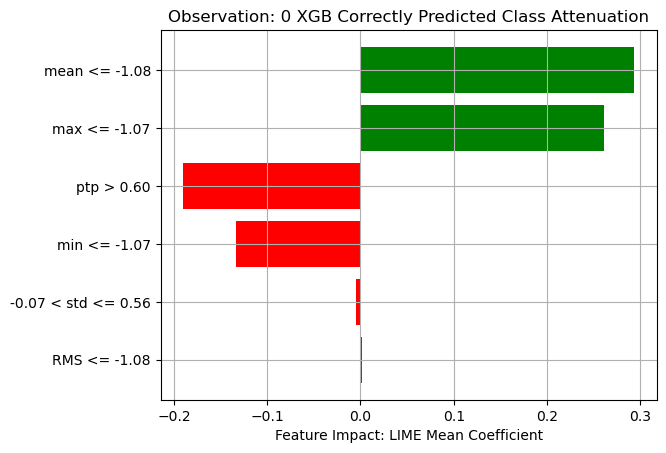

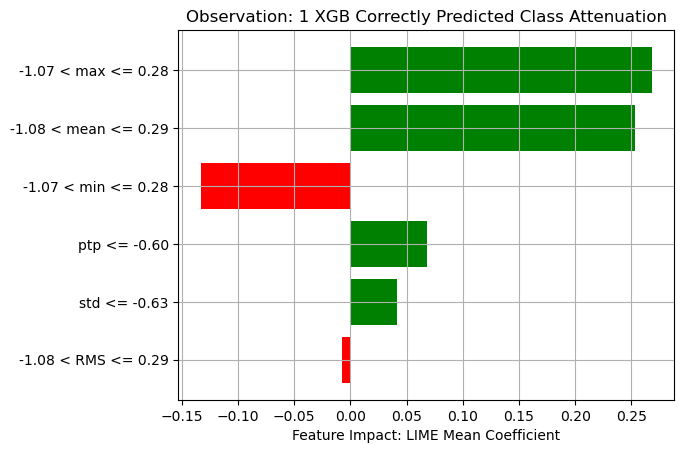

In [20]:
###########################################################################
###### Local explanations for some test data points
###########################################################################

fig_folder = '1_1_Figures_XAI'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)
    
#to perform local explanations, we will use the method 'explain_instance'. 
#explain_instance takes 4 arguments: 
    # 1) data point to explain X_test[n], 
    # 2) blackbox model prediction function rf.predict_proba
    # 3) number of features to visualize in the output figure 
    # 4) set of labels (we will define a labels array for this purpose)


# 1) for a given value of n, X_test[n] represents the test point to explain and the 1st argument to pass to explain_instance
# 2) rf.predict_proba represents the second argument to pass to explain_instance
# 3) num_features=15 to visualize on output figure the most important 15 features, this is the 3rd argument to pass to explain_instance
labels  = [0, 1] # 4) 4th argument to pass to explain_instance

N = 2 #number of test data points to explain

algs_labels = ['KNN', 'MLP', 'XGB']
models = [knn, dnn, xgb]

algs_y_pred = [y_pred_KNN, y_pred_DNN, y_pred_KNN]

for i, model in enumerate(models):
    # Let's explain 2 points in the test set:   
    for n in range(N):
        exp = explainer.explain_instance(X_test[n], model.predict_proba, num_features=15, labels=lbl) 
        #exp now represents the explanation of test data point X_test[n]

        #draw exp as a pyplot figure. Pass exp.as_pyplot_figure the predicted class
        fig = exp.as_pyplot_figure(int(algs_y_pred[i][n])) 

        #check if correct or wrong prediction and set appropriate plot title (using 'blackboxprediction' variable)
        if int(y_test[n]) == int(algs_y_pred[i][n]):
            blackboxprediction = algs_labels[i]+' Correctly Predicted Class %s' % exp.class_names[int(algs_y_pred[i][n])]
        else: 
            blackboxprediction = algs_labels[i]+' Wrongly Predicted Class %s' % exp.class_names[int(algs_y_pred[i][n])]        
        #set a title to figure
        title = "Observation: " + str(n) + ' ' + blackboxprediction 
        plt.title(title) 
        #set x-axis label and plot figure
        plt.xlabel('Feature Impact: LIME Mean Coefficient')
        plt.grid()
        plt.show()
        fig.savefig(fig_folder+'/'+title.replace(" ", "_").replace(":", "_")+'.png', bbox_inches='tight')


In [21]:
######################################################################################
###### Initialize the SHAP explainer and calculate/show SHAP values
######################################################################################

#set number of shap points to consider with SHAP, we can consider the whole dataset 
shappoints = 2500

# Rather than use the whole training set to estimate expected values, we could summarize with
# a set of weighted kmeans, each weighted by the number of points they represent. 
X_train_summary = shap.kmeans(X_train, 50)

alg_shap_values = []

for i in range(len(models)):
    # Create and initialize explainer
    explainer_shap = shap.KernelExplainer(models[i].predict_proba, X_train_summary)
    print('Calculating the SHAP values for '+ algs_labels[i] +'...')
    # Calculating the SHAP values by using shap_values method.
    shap_values = explainer_shap.shap_values(X_test[:shappoints])
    alg_shap_values.append(shap_values)


Calculating the SHAP values for KNN...


100%|██████████| 2500/2500 [16:10<00:00,  2.58it/s]


Calculating the SHAP values for MLP...


100%|██████████| 2500/2500 [01:49<00:00, 22.83it/s]


Calculating the SHAP values for XGB...


100%|██████████| 2500/2500 [03:36<00:00, 11.52it/s]


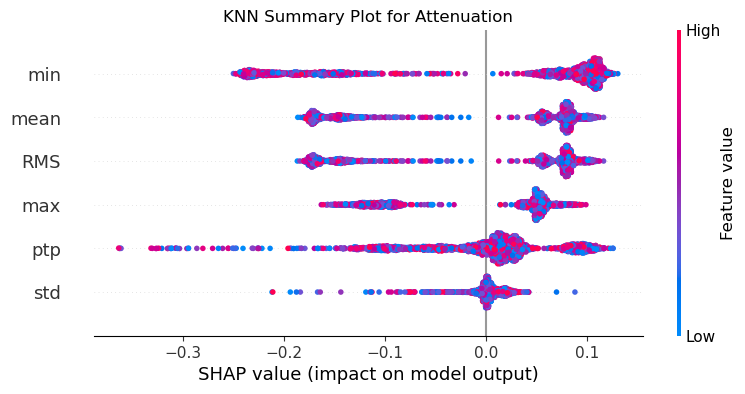

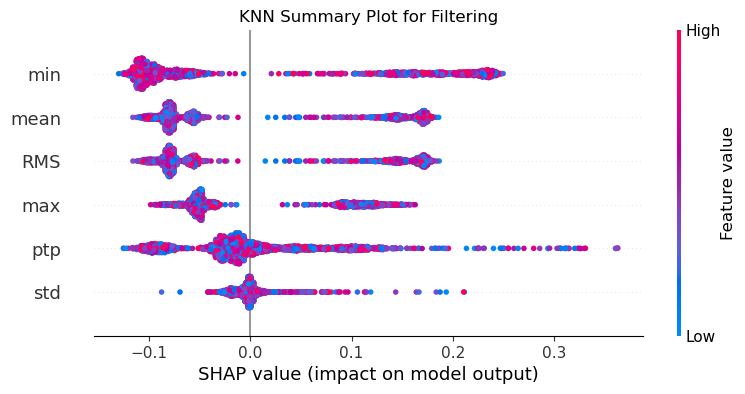

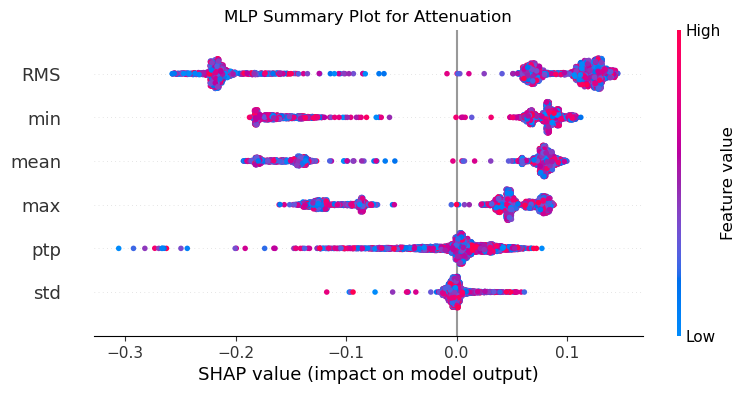

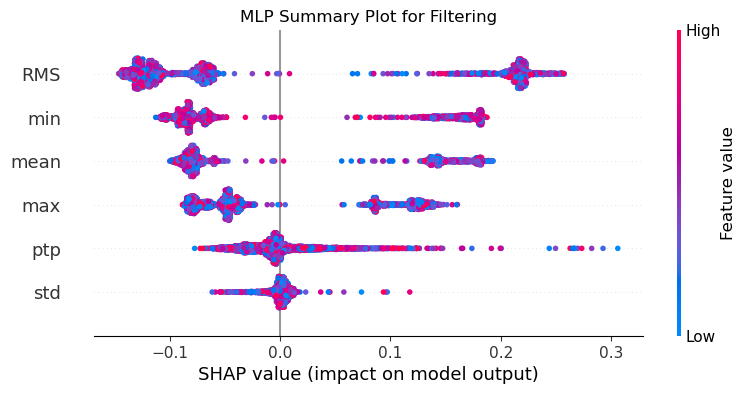

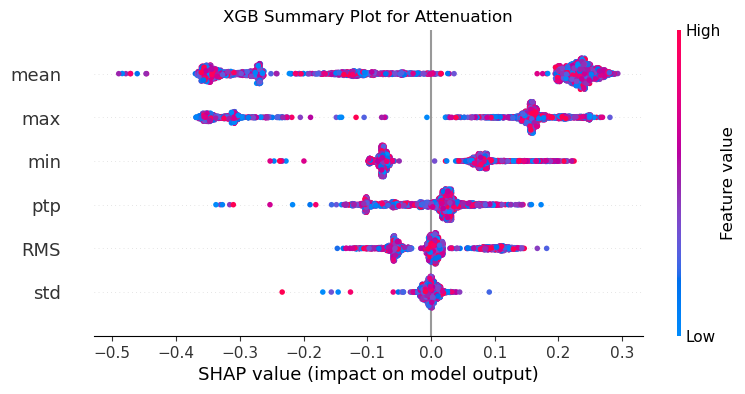

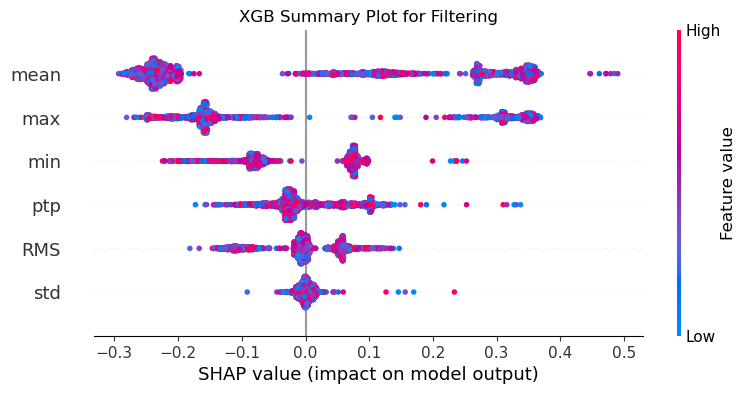

In [22]:
#####################################################################
###### SHAP Summary Plot for each of the classes
#####################################################################

for i in range(len(models)):
    #Iterate over labels (classes) and plot SHAP's summary plot of each label using shap.summary_plot method
    #method takes shap_values of the class, data set (from this SHAP gets features' values) and features names 
    #in addition to the number of features to display
    #we use show = False so the figure is not directly plotted so we can add a unique title to it in a next step
    for classitr in range(len(set(y))):
        fig=plt.gcf()
        shap.summary_plot(alg_shap_values[i][classitr], features=X[:shappoints], feature_names=feature_names, show = False, max_display=18)
        title = algs_labels[i] + ' Summary Plot for ' + str(label_names[classitr])
        plt.title(title)
        plt.show()
        fig.savefig(fig_folder+'/'+title.replace(" ", "_")+'.png', bbox_inches='tight')

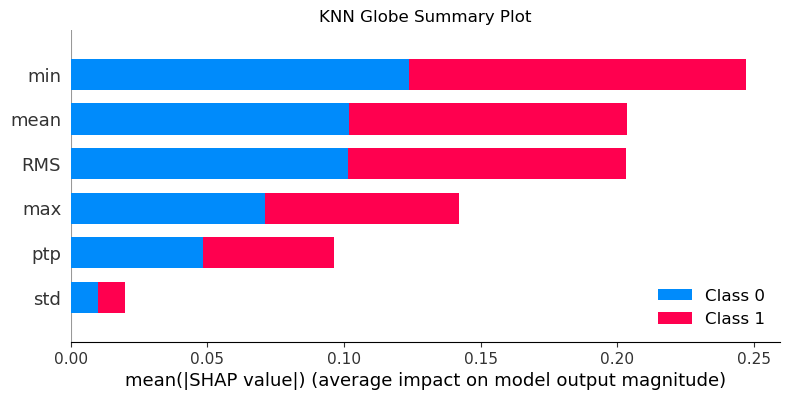

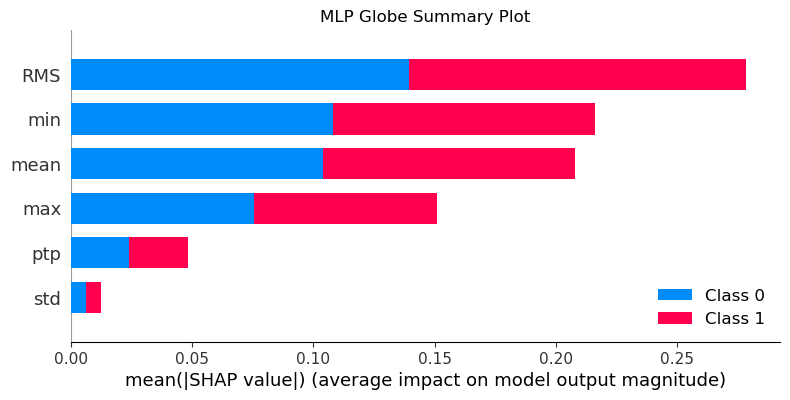

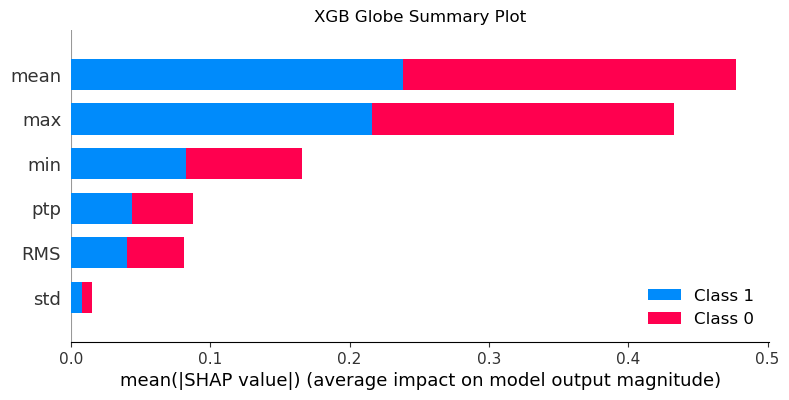

In [23]:
#######################################################################################
######  SHAP Globe Summary Plot
#######################################################################################

for i in range(len(models)):
    fig=plt.gcf()
    #Plot the overall summary plot (for all classes) using summary_plot method
    #We passed the method 4 arguments: 1) calculated SHAP values, 2) feature names, 3) show = False to not directly
    #plot the figure and 4) max_display to specify the number of features to display in figure
    shap.summary_plot(alg_shap_values[i], feature_names=feature_names, show = False, max_display=18)
    title = algs_labels[i] + " Globe Summary Plot"
    plt.title(title)
    plt.show()
    fig.savefig(fig_folder+'/'+title.replace(" ", "_")+'.png', bbox_inches='tight')
    